# A workaround to create a quantum circuit that produce a target quantum state from all-zero states


Created by Rudy Raymond (rudyhar@jp.ibm.com)


## Bug (a feature?) in the latest qiskit

The `circuit.initialize()` in qiskit is used to create a target quantum state from the all-zero quantum state. The latest version of qiskit inserts `reset` operations, which are not unitaries, and hence rendering the circuit cannot be inverted. Here, we show how to remove the `reset` operations from the circuit and obtain the circuit and inverse. 


In [1]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer, BasicAer
from scipy.special import erfinv
from scipy import optimize
import sys, time, math
import mpmath as mp
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from datetime import datetime

# importing circuit drawing
from qiskit.tools.visualization import plot_histogram

import sys
import logging
logging_level = logging.INFO
logging.basicConfig(level=logging_level,stream= sys.stdout)

my_style = {'usepiformat': True, 'cregbundle': True}

## Step 1. Create a circuit for generating the desired vector

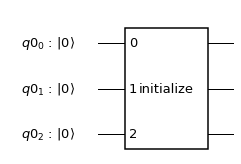

In [2]:
# Initializing a three-qubit quantum state
import math
desired_vector = [
    1 / math.sqrt(16) * complex(0, 1),
    1 / math.sqrt(8) * complex(1, 0),
    1 / math.sqrt(16) * complex(1, 1),
    0,
    0,
    1 / math.sqrt(8) * complex(1, 2),
    1 / math.sqrt(16) * complex(1, 0),
    0]


q = QuantumRegister(3)

qc = QuantumCircuit(q)

qc.initialize(desired_vector, [q[0],q[1],q[2]])
qc.draw(output='mpl')

## Step 2. Get the qasm strings, remove lines of `reset`, and create quantum circuit from the qams strings.  

In [8]:
from qiskit.transpiler.passes import Unroller
from qiskit.converters import circuit_to_dag, dag_to_circuit

dag = circuit_to_dag(qc)
pass_ = Unroller(basis=['u3', 'cx', 'id'])
unrolled_dag = pass_.run(dag)
unrolled_circuit = dag_to_circuit(unrolled_dag)
import re
#print(unrolled_circuit.qasm())
qc_without_reset = re.sub("reset.*\n", "", unrolled_circuit.qasm())
print(qc_without_reset)
qc = QuantumCircuit.from_qasm_str(qc_without_reset)
qc.draw(style= "mpl")

OPENQASM 2.0;
include "qelib1.inc";
qreg q0[3];
u3(1.95519310129054,0,0) q0[2];
u3(0,0,-0.312261443099564) q0[2];
cx q0[2],q0[1];
u3(0.378441833832614,0,0) q0[1];
cx q0[2],q0[1];
u3(0.990996572171952,0,0) q0[1];
cx q0[2],q0[1];
u3(0,0,0.0804376385991606) q0[1];
cx q0[2],q0[1];
u3(0,0,-0.473136720297885) q0[1];
cx q0[2],q0[0];
u3(-0.307739854335194,0,0) q0[0];
cx q0[1],q0[0];
u3(-0.307739854335194,0,0) q0[0];
cx q0[1],q0[0];
cx q0[2],q0[0];
cx q0[1],q0[0];
u3(1.26305647245970,0,0) q0[0];
cx q0[1],q0[0];
u3(1.26305647245970,0,0) q0[0];
cx q0[2],q0[0];
u3(0,0,-0.865835801996609) q0[0];
cx q0[1],q0[0];
u3(0,0,-0.473136720297885) q0[0];
cx q0[1],q0[0];
cx q0[2],q0[0];
cx q0[1],q0[0];
u3(0,0,0.0804376385991605) q0[0];
cx q0[1],q0[0];
u3(0,0,-0.312261443099564) q0[0];



## Step 3. Get the circuit and its inverse

In [4]:
qc = QuantumCircuit.from_qasm_str(qc_without_reset)
inverse_of_qc = qc.inverse()

## We can confirm that the combined circuit and its inverse is the identity circuit

In [5]:
qc = QuantumCircuit.from_qasm_str(qc_without_reset)
myqc = qc + inverse_of_qc

In [6]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(myqc, backend)
qc_state = job.result().get_statevector(myqc)
qc_state

INFO:qiskit.providers.basicaer.statevector_simulator:"statevector_simulator" only supports 1 shot. Setting shots=1.


array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [7]:
myqc = inverse_of_qc + qc

In [8]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(myqc, backend)
qc_state = job.result().get_statevector(myqc)
qc_state

INFO:qiskit.providers.basicaer.statevector_simulator:"statevector_simulator" only supports 1 shot. Setting shots=1.


array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

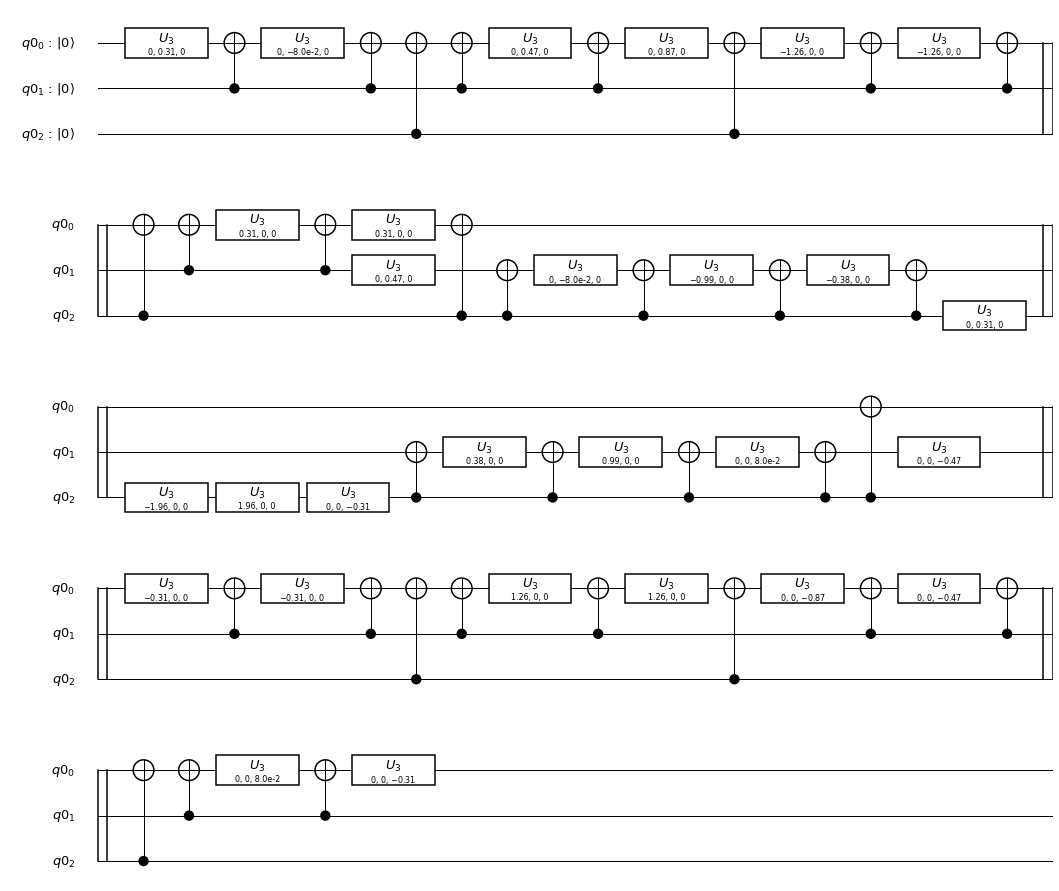

In [9]:
myqc.draw(output="mpl")